# Signal and background models

We now have all the components necessary for a complete signal model. We put them all together, and bin the spectrum according to the JUNO conventions. We also show the spectra of background components, digitized from the JUNO publication.

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

from neutrino_survival import NeutrinoSurvival
from ibd_kinematics import StrumiaVissani
from detector_response import JUNODetector
from neutrino_flux import NeutrinoFlux

In [2]:
ns = NeutrinoSurvival()
sv = StrumiaVissani()
E_nu_grid = np.linspace(1.8, 15.0, 5000)  # MeV
sv.build_total_cross_section_table(E_nu_grid)
detector = JUNODetector(sv)
flux = NeutrinoFlux(ns, sv)

detector.load_response_matrix()
E_nu_grid = detector.E_nu_grid  # MeV
E_rec_grid = detector.E_rec_grid  # MeV

Building total cross section table: 100%|██████████| 5000/5000 [00:10<00:00, 485.08it/s]


Response matrix loaded from juno_detector_response_matrix_79665791.npz


In [3]:
signal_rate_normal = flux.expected_signal_rate(
    E_nu_grid, "normal"
)  # per MeV per second
signal_rate_inverted = flux.expected_signal_rate(
    E_nu_grid, "inverted"
)  # per MeV per second

# Convolve with detector response
signal_rate_rec_normal = detector.apply_response_matrix(
    signal_rate_normal, E_nu_grid, E_rec_grid
)  # per MeV per second
signal_rate_rec_inverted = detector.apply_response_matrix(
    signal_rate_inverted, E_nu_grid, E_rec_grid
)  # per MeV per second

Binning of the JUNO paper: total of 340 bins.

In [4]:
bin_edges = (
    [
        0.8,
    ]
    + list(np.arange(0.94, 7.43, 0.02))
    + list(np.arange(7.44, 7.79, 0.04))
    + list(np.arange(7.80, 8.21, 0.10))
    + [12.0]
)
bin_edges = np.array(bin_edges)  # MeV
print(f"Number of bins: {len(bin_edges)-1}")

Number of bins: 340


We also load the background spectrum. It seems that individual spectra are only available at 1-5MeV, so only a sum of all backgrounds is included.

In [5]:
background_rate_file = np.loadtxt(
    "./data/juno_background.csv", delimiter=","
)  # events per 20 keV, 6.5 years exposure
background_rate_energies = background_rate_file[:, 0]  # MeV
background_rate = background_rate_file[:, 1]  # events per 20 keV per 6.5 years
background_rate /= 6.5 * 365.25 * 24 * 3600 * 20e-3  # events per MeV per second
background_rate_interp = scipy.interpolate.interp1d(
    background_rate_energies, background_rate, bounds_error=False, fill_value=0.0
)

# Expected background rate: 4.11 per day
# The extraction approach is very prone to small errors in reading the data points.
# We therefore correct the normalization by subtracting the entire spectrum by a small constant.
raw_bkg_rate = (
    scipy.integrate.quad(background_rate_interp, 0.8, 12.0)[0] * 86400
)  # Total background events each year between 0.8 and 12 MeV
correction = (raw_bkg_rate - 4.11) / (12.0 - 0.8) / 86400  # events per MeV per second
print(
    f"Background rate correction: {correction / background_rate_interp(1.5)} at 1.5 MeV"
)


def background_rate_corrected(E_rec):
    return background_rate_interp(E_rec) - correction

Background rate correction: 0.006944169604254169 at 1.5 MeV


/tmp/ipykernel_14789/4010110902.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scipy.integrate.quad(background_rate_interp, 0.8, 12.0)[0] * 86400


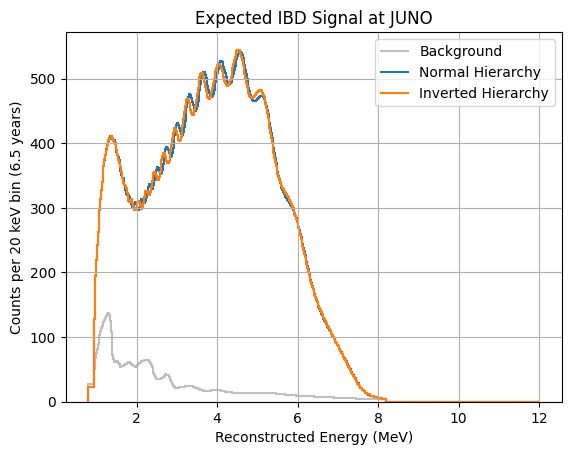

In [6]:
# Use a linear interpolator to integrate the rates in each bin
interp_normal = scipy.interpolate.interp1d(
    E_rec_grid,
    signal_rate_rec_normal,
    kind="linear",
    bounds_error=False,
    fill_value="extrapolate",
)
interp_inverted = scipy.interpolate.interp1d(
    E_rec_grid,
    signal_rate_rec_inverted,
    kind="linear",
    bounds_error=False,
    fill_value=0.0,
)

# Each bin count: integrate the rate over the bin width
bin_counts_normal = np.array(
    [
        scipy.integrate.quad(interp_normal, bin_edges[i], bin_edges[i + 1])[0]
        for i in range(len(bin_edges) - 1)
    ]
)
bin_counts_inverted = np.array(
    [
        scipy.integrate.quad(interp_inverted, bin_edges[i], bin_edges[i + 1])[0]
        for i in range(len(bin_edges) - 1)
    ]
)

# Add background
bin_counts_background = np.array(
    [
        scipy.integrate.quad(background_rate_corrected, bin_edges[i], bin_edges[i + 1])[
            0
        ]
        for i in range(len(bin_edges) - 1)
    ]
)

# Normalize to 6.5 years of data taking
exposure_time = 6.5 * 86400 * 365.25  # seconds
bin_counts_normal *= exposure_time
bin_counts_inverted *= exposure_time
bin_counts_background *= exposure_time
# Also divide by bin width to get counts per 20 keV
bin_widths = np.diff(bin_edges) * 50  # 20 keV
bin_counts_normal_plot = bin_counts_normal / bin_widths
bin_counts_inverted_plot = bin_counts_inverted / bin_widths
bin_counts_background_plot = bin_counts_background / bin_widths

plt.stairs(
    bin_counts_background_plot,
    bin_edges,
    label="Background",
    linewidth=1.5,
    color="gray",
    alpha=0.5,
)
plt.stairs(bin_counts_normal_plot, bin_edges, label="Normal Hierarchy", linewidth=1.5)
plt.stairs(
    bin_counts_inverted_plot, bin_edges, label="Inverted Hierarchy", linewidth=1.5
)
plt.xlabel("Reconstructed Energy (MeV)")
plt.ylabel("Counts per 20 keV bin (6.5 years)")
# plt.yscale('log')
plt.title("Expected IBD Signal at JUNO")
plt.legend()
plt.grid()
plt.show()

In [7]:
asimov_data_normal = bin_counts_normal + bin_counts_background


# We calculate the chi-square values for both hypotheses
def chi_square(asimov_data, expected_data):
    chi2 = np.sum((asimov_data - expected_data) ** 2 / expected_data)
    return chi2


chi2_normal = chi_square(asimov_data_normal, bin_counts_normal + bin_counts_background)
chi2_inverted = chi_square(
    asimov_data_normal, bin_counts_inverted + bin_counts_background
)
delta_chi2 = chi2_inverted - chi2_normal
print(f"Delta chi-square (normal - inverted): {delta_chi2}")
print(f"Significance: {np.sqrt(abs(delta_chi2))} sigma")

Delta chi-square (normal - inverted): 69.11671004476496
Significance: 8.313646013919822 sigma


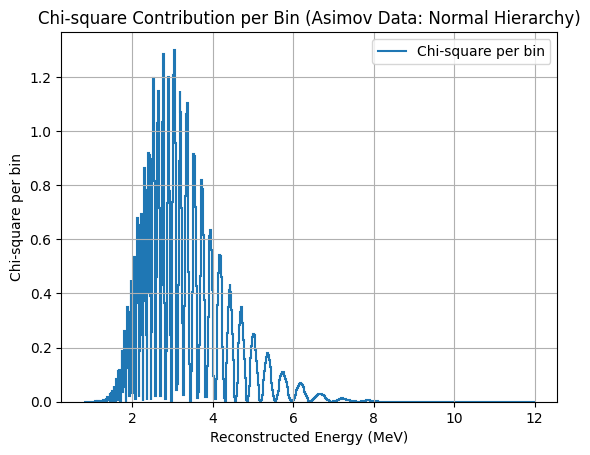

In [8]:
chi2 = (asimov_data_normal - bin_counts_inverted - bin_counts_background) ** 2 / (
    bin_counts_inverted + bin_counts_background
)
plt.stairs(chi2, bin_edges, label="Chi-square per bin", linewidth=1.5)
plt.xlabel("Reconstructed Energy (MeV)")
plt.ylabel("Chi-square per bin")
plt.title("Chi-square Contribution per Bin (Asimov Data: Normal Hierarchy)")
plt.legend()
plt.grid()
plt.show()

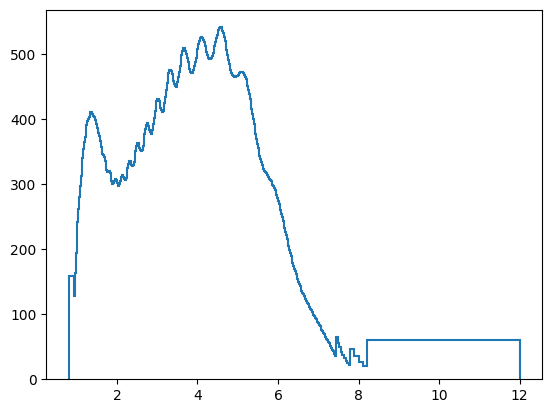

In [9]:
plt.stairs(bin_counts_normal, bin_edges, label="Normal Hierarchy", linewidth=1.5)

In [10]:
from signal_and_background import JUNOSignalAndBackground
import numpy as np
import scipy
from matplotlib import pyplot as plt

from neutrino_survival import NeutrinoSurvival
from ibd_kinematics import StrumiaVissani
from detector_response import JUNODetector
from neutrino_flux import NeutrinoFlux

ns = NeutrinoSurvival(delta_m32_squared=[0.002453, -0.002546])
sv = StrumiaVissani()
E_nu_grid = np.linspace(1.8, 15.0, 5000)  # MeV
sv.build_total_cross_section_table(E_nu_grid)
detector = JUNODetector(sv)
detector.load_response_matrix()
nf = NeutrinoFlux(ns, sv)

signal_and_bkg = JUNOSignalAndBackground(ns, sv, detector, nf, exposure_years=6.5)
bin_counts_normal = signal_and_bkg.calculate_expected_events(hierarchy="normal")
bin_counts_inverted = signal_and_bkg.calculate_expected_events(hierarchy="inverted")

Building total cross section table: 100%|██████████| 5000/5000 [00:10<00:00, 483.30it/s]


Response matrix loaded from juno_detector_response_matrix_79665791.npz


In [11]:
def get_new_signal_and_bkg(delta_m32_squared):
    new_ns = NeutrinoSurvival(delta_m32_squared=delta_m32_squared)
    new_nf = NeutrinoFlux(new_ns, sv)
    new_signal_and_bkg = JUNOSignalAndBackground(
        new_ns, sv, detector, new_nf, exposure_years=6.5
    )
    new_bin_counts_normal = new_signal_and_bkg.calculate_expected_events(
        hierarchy="normal"
    )
    new_bin_counts_inverted = new_signal_and_bkg.calculate_expected_events(
        hierarchy="inverted"
    )
    return new_bin_counts_normal, new_bin_counts_inverted

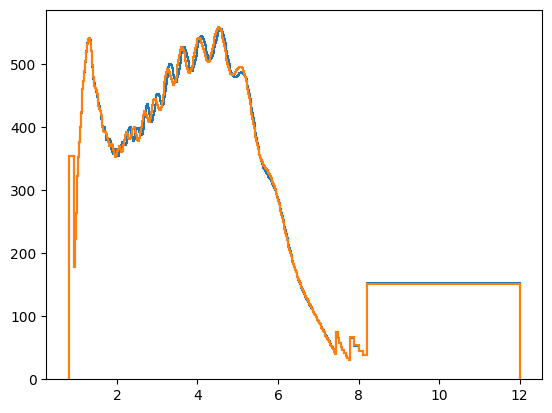

In [12]:
plt.stairs(
    bin_counts_normal, signal_and_bkg.bin_edges, label="Normal Hierarchy", linewidth=1.5
)
plt.stairs(
    bin_counts_inverted,
    signal_and_bkg.bin_edges,
    label="Inverted Hierarchy",
    linewidth=1.5,
)